In [1]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
from pyproj import Transformer
from rasterio.crs import CRS
from tqdm import tqdm
import concurrent.futures
import numpy as np

In [2]:
df_site_subset = gpd.read_file('../../../dist-s1-research/marshak/3_dist_sites/sites_for_processing_may_2024.geojson')
df_site_subset.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490)
2,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891)
3,30,noChange,No Change,NaT,NaT,31SDU,POINT (2.98892 34.90057)
4,34,VLmin,Wetland,2021-10-22,2021-10-08,13QFC,POINT (-103.52487 20.04769)


In [3]:
df_site_with_burst = gpd.read_file('../../../dist-s1-research_dev2/marshak/4_rtc_organization/val_sites_subset.geojson')
df_site_with_burst.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [4]:
df_subset_final = pd.merge(df_site_subset, df_site_with_burst[['site_id', 'jpl_burst_id']], on='site_id')
df_subset_final.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry,jpl_burst_id
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490),T036-076228-IW3
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490),T108-230715-IW2
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490),T101-214979-IW1
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891),T014-028130-IW2
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891),T021-043823-IW2


In [5]:
df_subset_final.to_file('val_sites_subset_with_all_metadata.geojson', driver='GeoJSON')

In [6]:
df_site_cc = df_subset_final[df_subset_final.change_type.str.lower().str.contains('fire')].reset_index(drop=True)
df_site_cc

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry,jpl_burst_id
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490),T036-076228-IW3
1,40,VLmaj,Fire,2021-10-03,NaT,10TFK,POINT (-121.17765 40.39154),T137-292355-IW2
2,40,VLmaj,Fire,2021-10-03,NaT,10TFK,POINT (-121.17765 40.39154),T042-088900-IW3
3,73,VLmin,Fire,2021-12-12,2021-12-06,36NWK,POINT (33.35820 4.05744),T029-060159-IW3
4,73,VLmin,Fire,2021-12-12,2021-12-06,36NWK,POINT (33.35820 4.05744),T123-263100-IW1
5,250,VLmaj,Clear cut/fire,2022-09-03,2022-08-29,29TPG,POINT (-7.52849 41.84227),T074-157046-IW1
6,250,VLmaj,Clear cut/fire,2022-09-03,2022-08-29,29TPG,POINT (-7.52849 41.84227),T125-267168-IW1


In [8]:
K = 5

# target_mgrs = 29TPG
df_site_cc.iloc[K]
site_id = df_site_cc.site_id[K]
burst_id = df_site_cc.jpl_burst_id[K]
lon = df_site_cc.geometry[K].x
lat = df_site_cc.geometry[K].y
change_time = df_site_cc.change_time[K]
lon, lat

(-7.52848790789017, 41.8422654005767)

In [10]:
df_rtc = pd.read_json('../../../dist-s1-research/marshak/4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()
df_ts = df_rtc[df_rtc.jpl_burst_id == burst_id].reset_index(drop=True)
df_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T074-157046-IW1_20201002T18201...,S1A_IW_SLC__1SDV_20201002T181957_20201002T1820...,T074-157046-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-02 18:19:57
1,OPERA_L2_RTC-S1_T074-157046-IW1_20201008T18193...,S1B_IW_SLC__1SDV_20201008T181929_20201008T1819...,T074-157046-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-08 18:19:29
2,OPERA_L2_RTC-S1_T074-157046-IW1_20201014T18201...,S1A_IW_SLC__1SDV_20201014T181957_20201014T1820...,T074-157046-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-14 18:19:57
3,OPERA_L2_RTC-S1_T074-157046-IW1_20201020T18192...,S1B_IW_SLC__1SDV_20201020T181929_20201020T1819...,T074-157046-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-20 18:19:29
4,OPERA_L2_RTC-S1_T074-157046-IW1_20201026T18201...,S1A_IW_SLC__1SDV_20201026T181957_20201026T1820...,T074-157046-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-26 18:19:57


In [11]:
url = df_ts.rtc_s1_vh_url[0]
with rasterio.open(url) as src:
    src_crs = src.crs
    
transformer = Transformer.from_crs(CRS.from_epsg(4326),
                                   src_crs, 
                                   always_xy=True)
utm_x, utm_y = transformer.transform(lon, lat)

def read_pixel_from_raster(raster_path, utm_x, utm_y) -> float:
    with rasterio.open(raster_path) as src:
        src_trans = src.transform

    row, col = rowcol(src.transform, utm_x, utm_y)
    row_m1 = max(row - 1, 0)
    col_m1 = max(col - 1, 0)
    window = Window(col_m1, row_m1, 3, 3)

    with rasterio.open(raster_path) as src:
        values = src.read(1, window=window).ravel()
    return np.nanmean(values)

In [12]:
%%time
N = df_ts.shape[0]
def read_pixel_from_raster_p(url):
    return read_pixel_from_raster(url, utm_x, utm_y)
    
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    vh_vals = list(tqdm(executor.map(read_pixel_from_raster_p, df_ts.rtc_s1_vh_url), total=N))
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    vv_vals = list(tqdm(executor.map(read_pixel_from_raster_p, df_ts.rtc_s1_vv_url), total=N))

100%|██████████| 102/102 [00:50<00:00,  2.03it/s]

CPU times: user 19.3 s, sys: 10.6 s, total: 29.9 s
Wall time: 2min 11s


(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

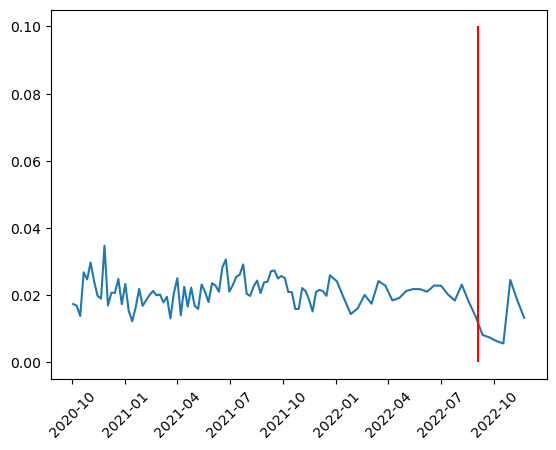

In [13]:
dts = [pd.to_datetime(dt) for dt in df_ts.acq_datetime]
plt.plot(dts, vh_vals)
plt.vlines(change_time, 0, .1, color='red')
plt.xticks(rotation=45)


(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

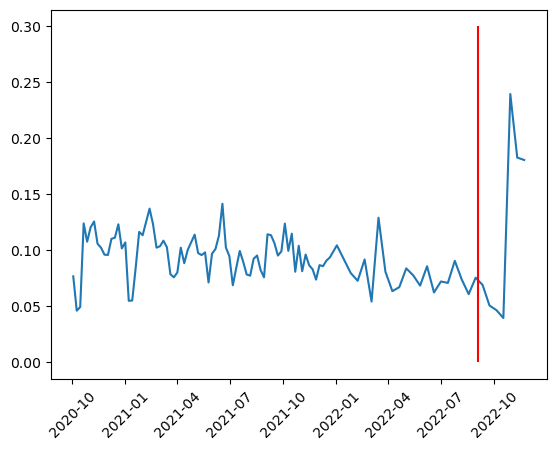

In [14]:
plt.plot(dts, vv_vals)
plt.vlines(change_time, 0, .3, color='red')
plt.xticks(rotation=45)

(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

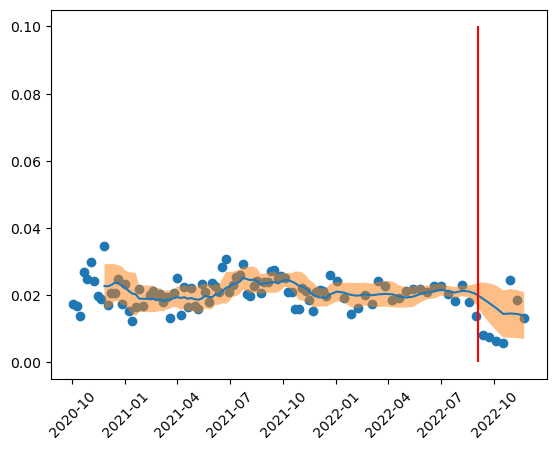

In [15]:
vh_ra = pd.Series(vh_vals).rolling(window=10).mean()
vh_std = pd.Series(vh_vals).rolling(window=10).std()

plt.scatter(dts, vh_vals)
plt.plot(dts, vh_ra)
plt.fill_between(dts, vh_ra - vh_std, vh_ra + vh_std, alpha=.5)

plt.vlines(change_time, 0, .1, color='red')
plt.xticks(rotation=45)

## Spatial Pattern Analysis with DIST-HLS

In [16]:
def read_rtc_entire(raster_path, window=None):
    with rasterio.open(raster_path) as src:
        if window is None:
            values = src.read()
            transform = src.transform
        else:
            values = src.read(1, window=window)
            transform = src.window_transform(window)
        crs = src.crs

    return values, (crs, transform)

def read_date_from_rtc(path):
    filename = path.split('/')[-1]
    datestr = filename.split('_')[4]
    return datestr

In [17]:
from pyproj import Proj, transform

proj_wgs84 = Proj(init='epsg:4326')

def latlon_to_tiff_crs(lat, lon, proj_tiff):
    x, y = transform(proj_wgs84, proj_tiff, lon, lat)
    return x, y

/mnt/aurora-r0/jungkyo/tool/miniforge3/envs/dist-s1-3/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
date_str_col = []

for t, row in df_ts.iterrows():
    time = pd.to_datetime(row['acq_datetime'])
    
    date_str_col.append(time)

In [19]:
last_scene_ind = 0
for time_ind, timeaa in enumerate(date_str_col):
    
    if timeaa < change_time:
        last_scene_ind = time_ind
after_event = last_scene_ind + 1
before_event = last_scene_ind - 3
print(last_scene_ind, after_event)

94 95


In [20]:
before_scene, before_crs = read_rtc_entire(df_ts.rtc_s1_vv_url[before_event])
last_scene, last_crs = read_rtc_entire(df_ts.rtc_s1_vv_url[last_scene_ind])
post_change_scene, post_crs = read_rtc_entire(df_ts.rtc_s1_vv_url[after_event])

Change date 2022-09-03 00:00:00


Text(0.5, 1.0, '20220910T182023Z')

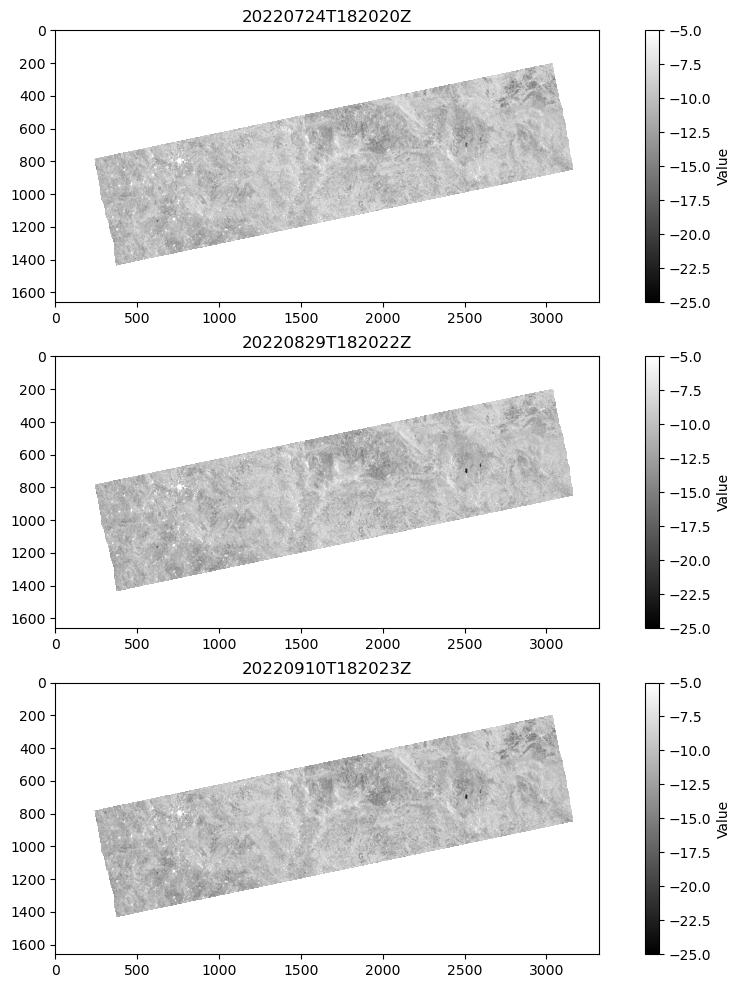

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
before_date = read_date_from_rtc(df_ts.rtc_s1_vv_url[before_event])
closest_date = read_date_from_rtc(df_ts.rtc_s1_vv_url[last_scene_ind])
post_date = read_date_from_rtc(df_ts.rtc_s1_vv_url[after_event])

# Plot 2019+2020 Detected changes
print('Change date', change_time)
im1 = axes[0].imshow(np.squeeze(10 * np.log10(before_scene)), cmap='gray', vmin=-25, vmax=-5)
plt.colorbar(im1, ax=axes[0], label='Value')
axes[0].set_title(f'{read_date_from_rtc(df_ts.rtc_s1_vv_url[before_event])}')

im2 = axes[1].imshow(np.squeeze(10 * np.log10(last_scene)), cmap='gray', vmin=-25, vmax=-5)
plt.colorbar(im2, ax=axes[1], label='Value')
axes[1].set_title(f'{read_date_from_rtc(df_ts.rtc_s1_vv_url[last_scene_ind])}')

im3 = axes[2].imshow(np.squeeze(10 * np.log10(post_change_scene)), cmap='gray', vmin=-25, vmax=-5)
plt.colorbar(im3, ax=axes[2], label='Value')
axes[2].set_title(f'{read_date_from_rtc(df_ts.rtc_s1_vv_url[after_event])}')



In [23]:
from shapely.geometry import box
latitude = df_site_cc.iloc[K].geometry.y
longitude = df_site_cc.iloc[K].geometry.x
x, y = latlon_to_tiff_crs(df_site_cc.iloc[K].geometry.y, df_site_cc.iloc[K].geometry.x, post_crs[0])


/tmp/ipykernel_133440/680230036.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = transform(proj_wgs84, proj_tiff, lon, lat)


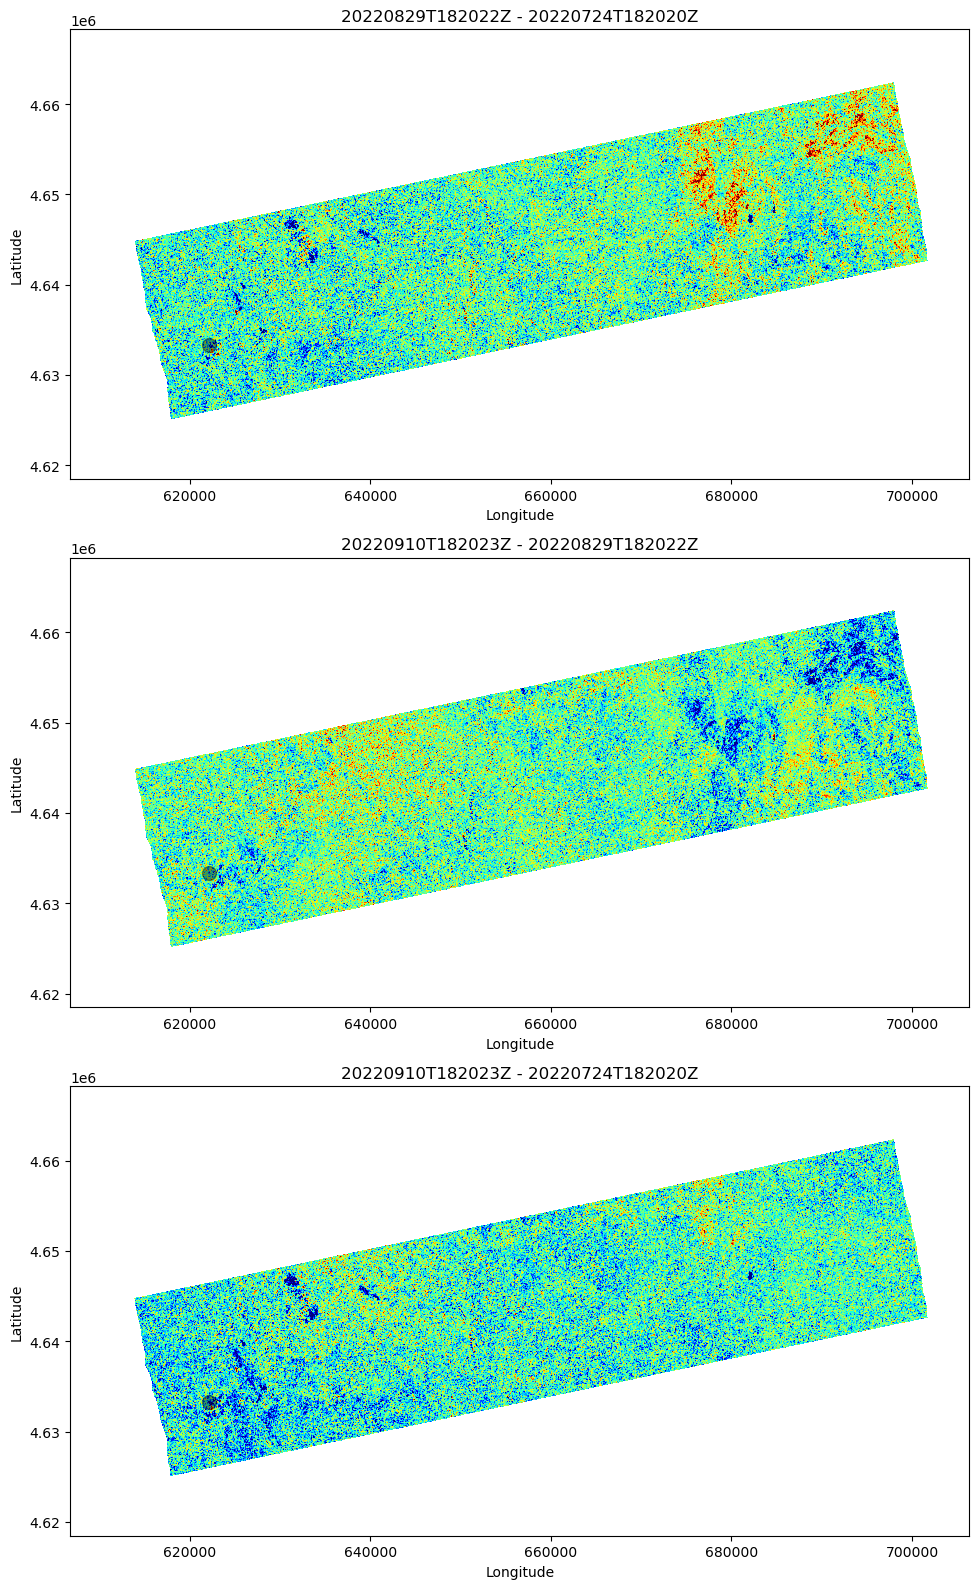

In [24]:
from rasterio.plot import show

fig, axes = plt.subplots(3, 1, figsize=(18, 16))
show(10 * np.log10(np.squeeze(last_scene/before_scene)), transform=last_crs[1], ax=axes[0], cmap='jet', vmin=-2, vmax=2)

plt.xlabel(f'Eastings ({last_crs[0].to_string()})')
plt.ylabel(f'Northings ({last_crs[0].to_string()})')
axes[0].set_title(f'{closest_date} - {before_date}')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].plot(x, y, marker='o', color='black', markersize=10, alpha = 0.4)  # Ensure points are plotted after the image

show(10 * np.log10(np.squeeze(post_change_scene/last_scene)), transform=last_crs[1], ax=axes[1], cmap='jet', vmin=-2, vmax=2)
plt.xlabel(f'Eastings ({last_crs[0].to_string()})')
plt.ylabel(f'Northings ({last_crs[0].to_string()})')
axes[1].set_title(f'{post_date} - {closest_date}')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].plot(x, y, marker='o', color='black', markersize=10, alpha = 0.4)  # Ensure points are plotted after the image

show(10 * np.log10(np.squeeze(post_change_scene/before_scene)), transform=last_crs[1], ax=axes[2], cmap='jet', vmin=-2, vmax=2)
plt.xlabel(f'Eastings ({last_crs[0].to_string()})')
plt.ylabel(f'Northings ({last_crs[0].to_string()})')
axes[2].set_title(f'{post_date} - {before_date}')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].plot(x, y, marker='o', color='black', markersize=10, alpha = 0.4)  # Ensure points are plotted after the image

plt.tight_layout()
plt.show()


In [ ]:
## Compare with DIST-HLS

In [26]:
mgrs = df_site_cc.mgrs_tile_id[K]
mgrs

'29TPG'

In [33]:
df_dist_hls = pd.read_json('dist-hls_path_with_mgrs.json')
df_dist_hls.head()



,Date,MGRS,Type,DIST-HLS_path
0,2021-10-02 07:55:54,T36MYD,DATA-MASK,https://glad.umd.edu/projects/opera/SEP/v1samp...
1,2021-10-02 07:55:54,T36MYD,GEN-ANOM-MAX,https://glad.umd.edu/projects/opera/SEP/v1samp...
2,2021-10-02 07:55:54,T36MYD,GEN-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...
3,2021-10-02 07:55:54,T36MYD,GEN-DIST-CONF,https://glad.umd.edu/projects/opera/SEP/v1samp...
4,2021-10-02 07:55:54,T36MYD,GEN-DIST-COUNT,https://glad.umd.edu/projects/opera/SEP/v1samp...


In [36]:
filtered_dist_hls = df_dist_hls[(df_dist_hls.MGRS == f'T{mgrs}') & (df_dist_hls.Type == 'VEG-ANOM')]
filtered_dist_hls.head()

,Date,MGRS,Type,DIST-HLS_path
176684,2021-10-01 11:21:21,T29TPG,VEG-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...
176705,2021-10-03 11:08:09,T29TPG,VEG-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...
176726,2021-10-04 11:33:21,T29TPG,VEG-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...
176747,2021-10-06 11:21:19,T29TPG,VEG-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...
176768,2021-10-08 11:09:51,T29TPG,VEG-ANOM,https://glad.umd.edu/projects/opera/SEP/v1samp...


In [39]:
def find_cloud_free(database, index, mode, product, nodata_threshold):
    num_data = np.shape(database)[0]
    print(index)
    if mode == 'forward':
        loop_array = np.arange(index, num_data)
    elif mode == 'backward':
        loop_array = np.arange(index, -1, -1)
    for file_ind in loop_array:
        print(file_ind)
        test_group = database.iloc[file_ind]['DIST-HLS_path']
        test_filename = get_filename(test_group, product)

        test_img, testcrs =  read_rtc_entire(test_filename)
        test_img = np.squeeze(test_img)
        num_pixel = test_img.shape[0] * test_img.shape[1]
        valid_pixel = np.sum(test_img < 200)
        if valid_pixel/num_pixel > nodata_threshold:
            print(index, file_ind)
            return test_filename, test_img, testcrs, index
    print('failed to find cloud-free')
    return None, None, None, None


def get_filename(filename, product):
    http_paths = filename.split('/')[:-1]
    http_path = '/'.join(http_paths)
    filename_comp = filename.split('/')[-1].split('_')[:-1]
    filename_comb = '_'.join(filename_comp)
    output_path = f'{http_path}/{filename_comb}_{product}.tif'
    return output_path

In [40]:
filtered_dist_hls = filtered_dist_hls.sort_values(by='Date').reset_index(drop=True)

# Find the filename with the closest date to the target date
filtered_dist_hls['date_diff'] = (filtered_dist_hls['Date'] - change_time).abs()
closest_index = filtered_dist_hls['date_diff'].idxmin()

# Get the closest one and one before and after
closest_filename = filtered_dist_hls.iloc[closest_index]['DIST-HLS_path']
before_filename = filtered_dist_hls.iloc[closest_index - 1]['DIST-HLS_path'] if closest_index > 0 else None
after_filename = filtered_dist_hls.iloc[closest_index + 1]['DIST-HLS_path'] if closest_index < len(filtered_dist_hls) - 1 else None

closest_date = filtered_dist_hls.iloc[closest_index]['Date']
before_date = filtered_dist_hls.iloc[closest_index -1 ]['Date']
after_date = filtered_dist_hls.iloc[closest_index + 1]['Date']


product = 'VEG-ANOM'
closest_product = get_filename(closest_filename, product)
before_product = get_filename(before_filename, product)
after_product = get_filename(after_filename, product)

In [42]:
print(closest_product)
print(before_product)
print(after_product)

https://glad.umd.edu/projects/opera/SEP/v1sample/DIST-ALERT_v1/2022/29/T/P/G/DIST-ALERT_2022246T110631_S30_T29TPG_v1/OPERA_L3_DIST-ALERT-HLS_T29TPG_20220903T110631Z_20231206T163806Z_S2A_30_v1_VEG-ANOM.tif
https://glad.umd.edu/projects/opera/SEP/v1sample/DIST-ALERT_v1/2022/29/T/P/G/DIST-ALERT_2022245T110746_L30_T29TPG_v1/OPERA_L3_DIST-ALERT-HLS_T29TPG_20220902T110746Z_20231206T163754Z_L9_30_v1_VEG-ANOM.tif
https://glad.umd.edu/projects/opera/SEP/v1sample/DIST-ALERT_v1/2022/29/T/P/G/DIST-ALERT_2022247T113319_S30_T29TPG_v1/OPERA_L3_DIST-ALERT-HLS_T29TPG_20220904T113319Z_20231206T163818Z_S2B_30_v1_VEG-ANOM.tif


In [41]:

# Based on the visual inspection, the actual event starts before the "change_time"
pre_cloud_filename, pre_cloud_img, pre_cloudcrs, pre_ind = find_cloud_free(filtered_dist_hls, closest_index-36, 'backward', product, 0.5)
pre_cloud_date = filtered_dist_hls.iloc[pre_ind]['Date']


188
188
187
186
185
184
183
188 183


In [44]:
post_cloud_filename, post_cloud_img, post_cloudcrs, post_ind = find_cloud_free(filtered_dist_hls, closest_index-14, 'forward', product, 0.5)

post_cloud_date = filtered_dist_hls.iloc[post_ind ]['Date']
print(post_cloud_date)

210
210
211
212
213
214
215
210 215
2022-08-16 11:13:51


In [48]:
x2, y2 = latlon_to_tiff_crs(df_site_cc.iloc[K].geometry.y, df_site_cc.iloc[K].geometry.x, post_cloudcrs[0])
print(x2, y2)

622169.1348320569 4633310.027522224


/tmp/ipykernel_133440/680230036.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = transform(proj_wgs84, proj_tiff, lon, lat)


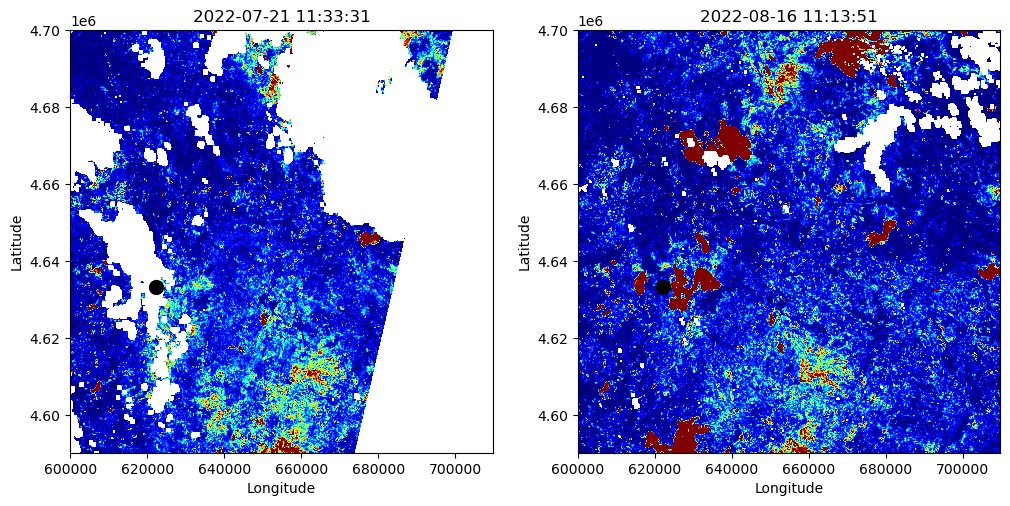

In [49]:
# Create the figure
pre_cloud_img = np.asarray(pre_cloud_img, dtype='float32')
post_cloud_img = np.asarray(post_cloud_img, dtype='float32')
pre_cloud_img[pre_cloud_img>200] = np.nan
post_cloud_img[post_cloud_img>200] = np.nan
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
show(np.squeeze(pre_cloud_img), transform=pre_cloudcrs[1], ax=axes[0] , cmap='jet', vmin=0, vmax=10)
plt.xlabel(f'Eastings ({pre_cloudcrs[0].to_string()})')
plt.ylabel(f'Northings ({pre_cloudcrs[0].to_string()})')
axes[0].set_title(pre_cloud_date)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].plot(x2, y2, marker='o', color='black', markersize=10)  # Ensure points are plotted after the image

show(np.squeeze(post_cloud_img), transform=post_cloudcrs[1], ax=axes[1], cmap='jet', vmin=0, vmax=10)
plt.xlabel(f'Eastings ({post_cloudcrs[0].to_string()})')
plt.ylabel(f'Northings ({post_cloudcrs[0].to_string()})')
axes[1].set_title(post_cloud_date)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].plot(x2, y2, marker='o', color='black', markersize=10)  # Ensure points are plotted after the image
